In [57]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.base import BaseEstimator
import seaborn as sns
import xgboost as xgb
import catboost as ctb
import eli5


from tqdm import tqdm

In [58]:
train = pd.read_hdf('../input/diabetic_train.h5')
test = pd.read_hdf('../input/diabetic_test.h5')

In [59]:
def __f15_score(y, y_pred):
    return fbeta_score(y, y_pred, beta=1.5)


f15_score  = make_scorer(__f15_score, greater_is_better=True)

In [60]:
def get_feats(df, black_list=["readmitted", "readmitted_cat", "id", "encounter_id"]):
    feats = df.select_dtypes("number").columns
    feats = [x for x in feats if x not in black_list]
    
    return feats


def get_X_y(df, feats=None):
    if feats is None:
        feats = get_feats(df)

    X = df[feats].values
    y = df['readmitted'].values
    
    return X, y

def feature_engineering(df, cat_features):
    for feature in cat_features:
        df['{}_cat'.format(feature)] = df[feature].factorize()[0]
    
    return df

In [61]:
df = pd.concat([train, test], sort=False)
df.fillna(-1, inplace=True)

/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


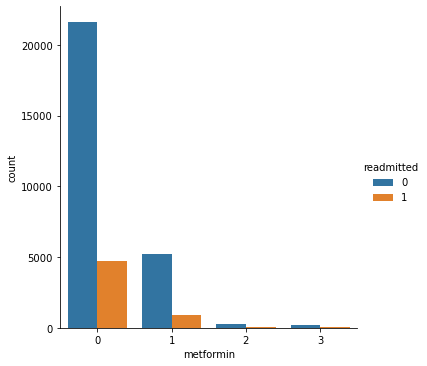

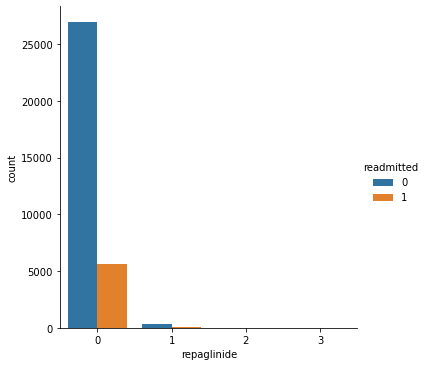

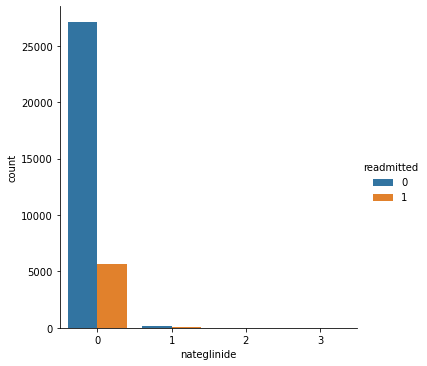

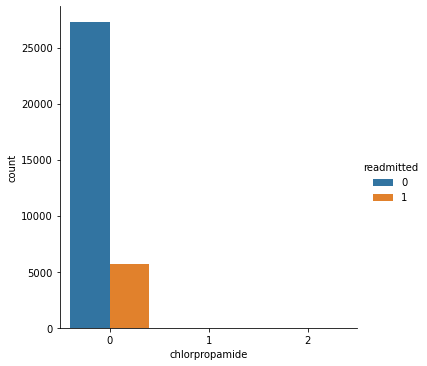

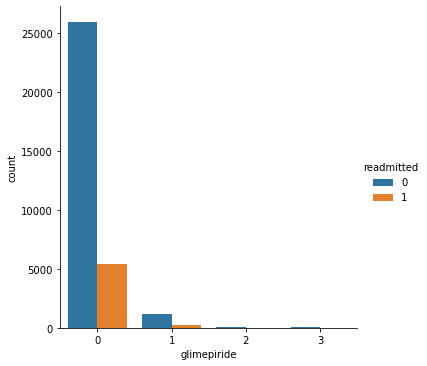

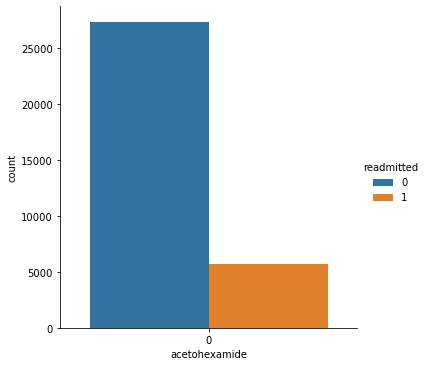

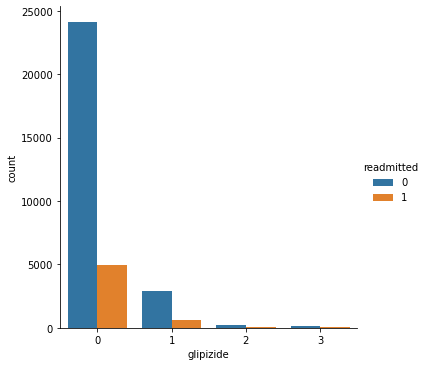

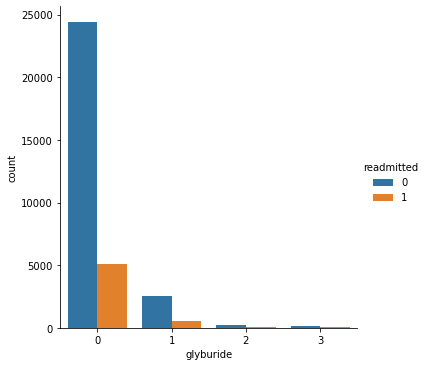

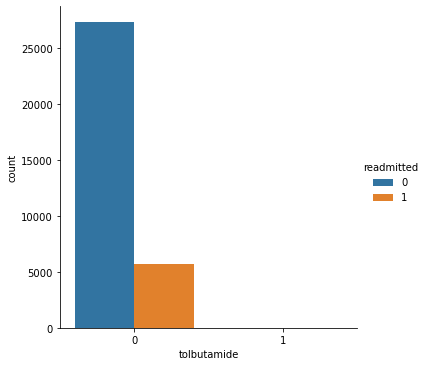

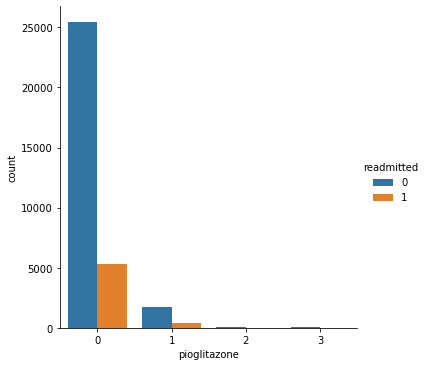

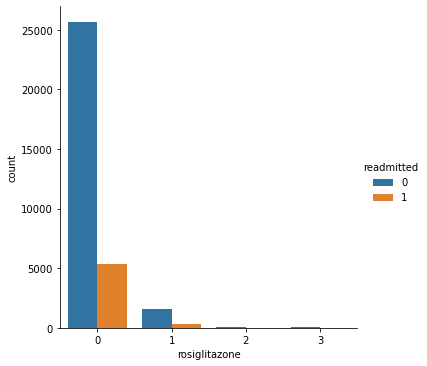

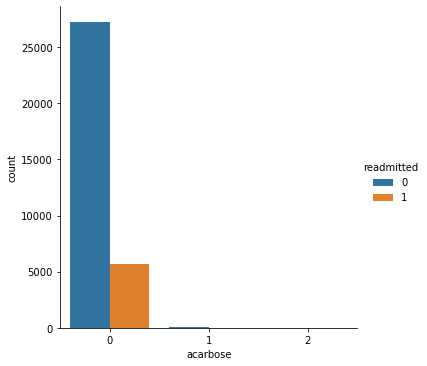

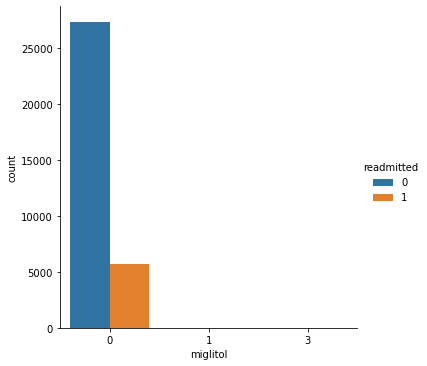

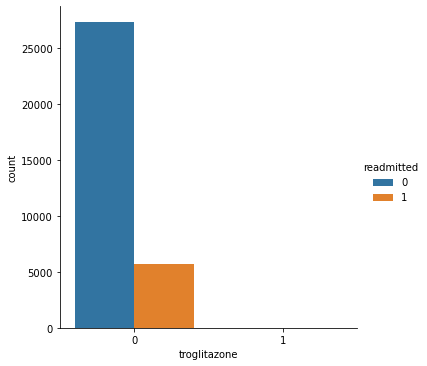

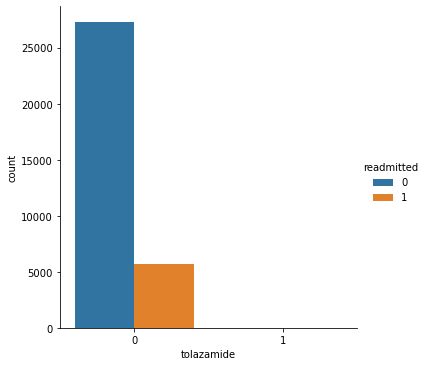

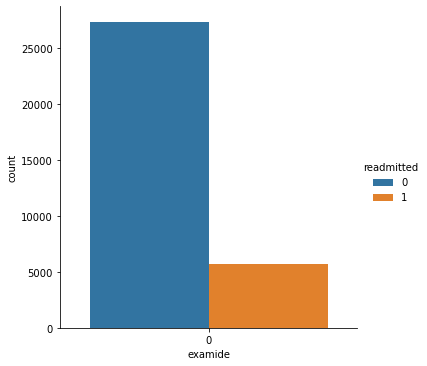

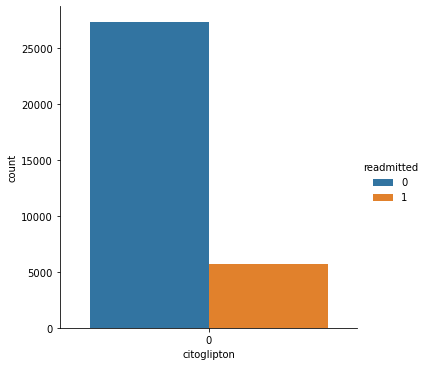

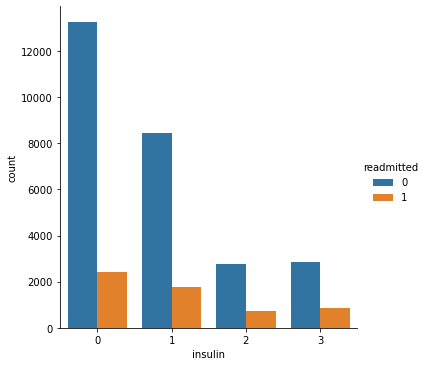

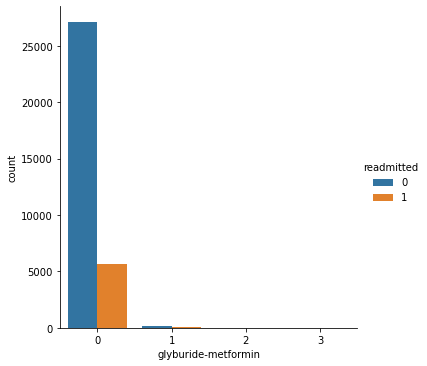

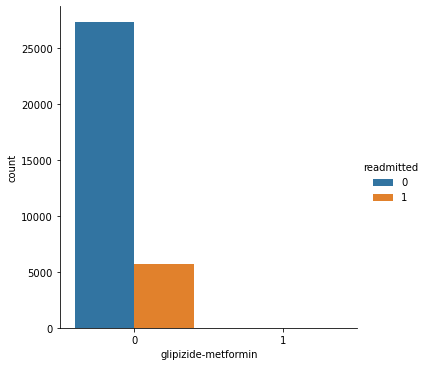

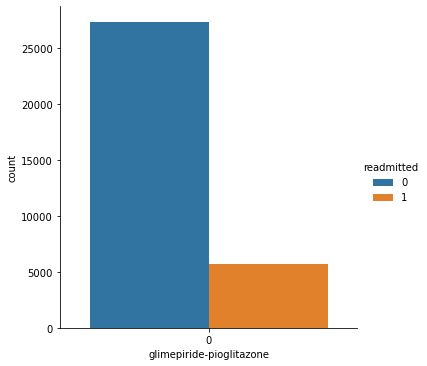

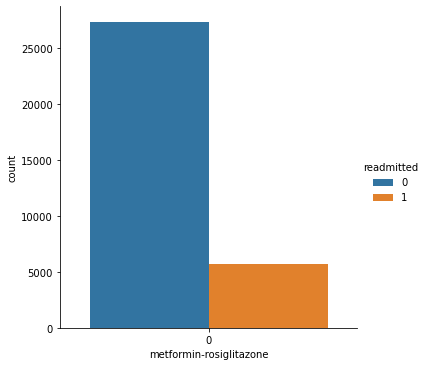

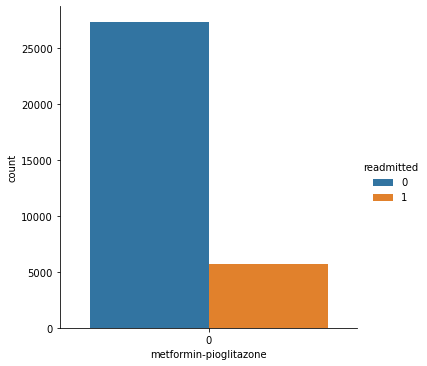

In [62]:
#medicaments plots
medicaments = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

for c in medicaments:
    sns.catplot(x=c,hue='readmitted',data=train,kind="count")

In [63]:
#joined feats
df["metformin_change"] = df["metformin"].astype(str) +"_"+df["change"].astype(str)
df["insulin_diabetesMed"] = df["insulin"].astype(str) +"_"+df["diabetesMed"].astype(str)
df["insulin_change"] = df["insulin"].astype(str) +"_"+df["change"].astype(str)
df["time_in_hospital_payer_code"] = df["time_in_hospital"].astype(str) +"_"+df["payer_code"].astype(str)
df["race_age"] = df["race"].astype(str) +"_"+df["age"].astype(str)
df["age_weight"] = df["age"].astype(str) +"_"+df["weight"].astype(str)
df["age_gender"] = df["age"].astype(str) +"_"+df["gender"].astype(str)


In [ ]:
#shifted feats 
df['prev_number_inpatient'] = df.groupby('patient_nbr')['number_inpatient'].shift(1)
df['prev_payer_code'] = df.groupby('patient_nbr')['payer_code'].shift(1)

In [30]:
#cumsum
df["temp"]=1
df["cumsum"] = df.sort_values(by='encounter_id').groupby(by=['patient_nbr'])['temp'].transform(lambda x: x.cumsum())
df["cumsum_change"] = df.sort_values(by='encounter_id').groupby(by=['patient_nbr'])['change'].transform(lambda x: x.cumsum())
df["%_of_changes"] = df["cumsum_change"]/df["cumsum"]

In [31]:
#mean value of time in hospital/ number diagnoses
t_pivot = df.pivot_table(values=["time_in_hospital", "number_diagnoses"], index=["patient_nbr"], aggfunc=np.mean).reset_index()
t_pivot.columns = ['patient_nbr','mean_time_in_hospital', 'mean_number_diagnoses']

df = pd.merge(df, t_pivot, on="patient_nbr", how="left")


In [32]:
# #A1Cresult per patient
t2 = df.pivot_table(index='patient_nbr', columns='A1Cresult', values='id', aggfunc='count').fillna(0).reset_index()
t2.columns = ['patient_nbr', 'pA1Cresult>7', 'pA1Cresult>8', 'pA1Cresult_None', 'pA1Cresult_Norm']

df = pd.merge(df, t2, on="patient_nbr", how="left")


In [33]:
#max_glu_serum per patient
t3 = train.pivot_table(index='patient_nbr', columns='max_glu_serum', values='id', aggfunc='count').fillna(0).reset_index()
t3.columns = ['patient_nbr', 'pmax_glu_serum>200', 'pmax_glu_serum>300', 'pmax_glu_serum_None', 'pmax_glu_serum_Norm']

df = pd.merge(df, t3, on="patient_nbr", how="left")

In [38]:
#ohe
df_discharge_disposition_id = pd.get_dummies( df['discharge_disposition_id'],prefix='discharge_disposition_id' )
df_admission_source_id = pd.get_dummies( df['admission_source_id'],prefix='admission_source_id' )
df_pioglitazone = pd.get_dummies( df['pioglitazone'],prefix='pioglitazone' )
df = pd.concat([df, df_discharge_disposition_id], axis=1)
df = pd.concat([df, df_admission_source_id], axis=1)
df = pd.concat([df, df_pioglitazone], axis=1)


In [39]:
# categotical to numeric
cat_features = df.select_dtypes(include=np.object).columns
df = feature_engineering(df.copy(), cat_features)

In [40]:
#payer code changed?
df.loc[(df['prev_payer_code'] == df['payer_code']), 'payer_code_change'] = 0
df.loc[df['payer_code_change'].isnull(), 'payer_code_change'] = 1

In [41]:
# df.payer_code_change.value_counts()
df.fillna(0)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,readmitted_cat,metformin_change_cat,insulin_diabetesMed_cat,insulin_change_cat,time_in_hospital_payer_code_cat,race_age_cat,prev_payer_code_cat,age_weight_cat,age_gender_cat,payer_code_change
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,0,0,0,0,0,0,-1,0,0,1.0
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,0,0,1,0,1,1,-1,1,1,1.0
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,0,1,2,1,1,2,-1,2,2,1.0
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,0,1,3,2,0,3,-1,3,3,1.0
4,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,0,1,3,2,2,4,-1,4,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66216,443842136,181593374,Caucasian,Female,[70-80),?,1,1,7,5,...,2,0,3,5,11,11,-1,7,8,1.0
66217,443842340,120975314,Caucasian,Female,[80-90),?,1,1,7,5,...,2,1,2,1,62,4,-1,4,4,1.0
66218,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,2,0,3,5,62,20,-1,4,4,1.0
66219,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,2,2,4,3,29,11,-1,7,13,1.0


# Modelling

In [42]:
feats = get_feats(df)
len(feats)

117

In [43]:
#train
train = df[ df.readmitted != ''].fillna(0)
X_train = train[feats].values
y_train = train['readmitted'].values

#test
test = df[ df.readmitted == ''].fillna(0)
X_test = df[ df.readmitted == ''][feats].values

In [44]:
train.readmitted = train.readmitted.astype(int)


In [45]:
feats = get_feats(train)
len(feats)

117

In [46]:
model = ctb.CatBoostClassifier(max_depth=6, n_estimators=100, learning_rate=0.21, random_state=0, verbose=False)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
threshold = 0.2
X, y = get_X_y(train)
scores = []
for train_idx, test_idx in tqdm(cv.split(X, y, groups=train["patient_nbr"])):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype("int8")
    
    score =  __f15_score(y_test, y_pred)
    scores.append(score)
    
np.mean(scores)

3it [00:06,  2.09s/it]


0.7207817089701835

Kaggle:
Public Score: 0.73114
Private Score: 0.7387

# Prognoza submit

In [47]:
threshold = 0.2
feats = get_feats(train)

X_train, y_train = get_X_y(train, feats)
X_test = test[feats].values

model = ctb.CatBoostClassifier(max_depth=6, n_estimators=100, learning_rate=0.21, random_state=0, verbose=False)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > threshold).astype("int8")

In [48]:
el = eli5.show_weights(model, feature_names=feats, top=40)
el

Weight,Feature
0.3442,pA1Cresult_None
0.1305,cumsum
0.0770,number_inpatient
0.0695,discharge_disposition_id_11
0.0550,pmax_glu_serum_None
0.0462,patient_nbr
0.0299,pA1Cresult>8
0.0204,A1Cresult_cat
0.0167,pA1Cresult_Norm
0.0131,num_lab_procedures


# Przygotowanie pliku, który możesz dodać na Kaggle

In [49]:
test['readmitted'] = y_pred
test[ ['id', 'readmitted'] ].to_csv('../output/submit_final.csv', index=False) 